Classifying handwritten digits (work in progress!)
-----
The MNIST dataset contains **labelled images of handwritten digits** - one common machine learning exercise
is to use this dataset to train a model to recognise such digits. In this write-up we will see why - it's
a difficult task but the methods give impressive results.

One of my personal goals here is to understand what all the fuss is about with
neural networks, by comparing them to other models in the context of this task.
In the course of implementing these models,
we'll take a look at **hyperparameter tuning**,
and some basic methods for **reducing the dimensionality** of the dataset.

Results
-------
**Results so far:** Confidence checks all looking good. Based on the validation set, we chose the two best models.
We estimated the accuracy of them using the test set - the
XGBClassifier model got an accuracy of 97.1%, and our MLPClassifier, which was dimensionally reduced using Legendre decomposition,
got 97.5%.

Main conclusion: the neural net converges way faster than the boosted decision trees I tested,
and is way more accurate than the linear svc model. There are definitely caveats to this - for example,
I didn't explore variations to the neural network architecture, I only varied very few of the parameters of the
other models, and for the sake of training time I reduced the size of the training data that the linear svc had
access to.

I played around with dimensional reduction too, and it seems like Legendre decomposition outperforms PCA, slightly.
PCA on the other hand has the obvious advantage that it is well known and easily included in the model pipeline.

Metrics
----
We will use sklearn.metrics.accuracy_score as our metric.
This is the fraction of the samples that were correctly classified. 
Any quoted times will be wall clock times as measured on my laptop - note these timings are not meant to be rigorous comparisons!
The loss function used by MLPClassifier is the cross-entropy, which acts to find the network parameters that maximise the likelihood of the training data **CHECK THIS!**

Models
-----
We will compare the following models in terms of both accuracy and speed. It won't be a totally
fair comparison, because (as specified below) we won't actually train all of these methods on the entire
training set, to keep computation time about even (in terms of wall clock time, not cpu-time).
1. **MLPClassifier**, a multi-layer perceptron (MLP). We will use a simple neural net with only one hidden layer.
2. **XGBoost** is a gradient boosted ensemble of decision trees.
    * Boosting (variance reduction for complex model).
    * Vs. bagging (bias reduction for simple model). Each tree in the random forest is fit to a random (bootstrapped) sample, so their errors should be uncorrelated. Occasionally you will have an outlier bag, but this will not be able to sway the majority vote at the end.
    * https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
    * It definitely has impressive CPU usage on my laptop!
3. **LinearSVC**, a support vector classifier with a linear kernel.
    * Should vary cache_size?
4. **GradientBoostingClassifier**, a gradient boosted ensemble of decision trees **?**

Preprocessing for dimensional reduction
------
The first bit of preprocessing that we (always) do is standardising our features,
by removing the mean and scaling to unit variance. But beyond that, we will attempt to
increase the signal-to-noise of our data by appying methods of dimensional reduction.
Why would we want to reduce the dimensionality of our dataset? Surely losing data is a bad thing?
One primary reason is **robustness to overfitting** - if we can drop
some of the noise in our training data, without losing signal, we will improve the generality of our model.
There are three types of dimensional reduction that we will look at here:
1. **None** - This dataset is small enough that we can just train on all the data. How well does this work, does it overfit on the noise?
2. **Principal component analysis** - PCA extracts the features that explain the majority of the variance. How well do these features function as predictors for the digits? 
3. **Polynomial decomposition** - We can expand the pixel image in a two-dimensional basis of Legendre polynomials. How well do the coefficients of this expansion function as predictors? Unlike PCA, this basis is not decided by the training set. This may increase its bias, but should also increase robustness to noise. There are two reasons for choosing Legendre polynomials. The first is that they are orthogonal on the interval [-1,1] and so the errors of the two-dimensional version should behave well on the squares our images live on. The second reason is personal - I have experience with them from my PhD, so I'm curious to see how they perform here! See "Visualising the Legendre basis" at the end of this notebook to see what the basis actually looks like.

There are multiple important differences between using PCA components as features and using Legendre coefficient as features.
For one thing, the PCA will converge to a (near-)perfect reconstruction of the
image as the number of components approaches the dimension of the data,
whereas the Legendre decomposition will require many more modes.
The Legendre decomposition will be especially bad at reconstructing sharp edges.
However, **the processed features do not actually have to reconstruct the original features well** - they just have to preserve the information that distinguishes the digits.

Confidence checking
-----
A large fraction of the time spent learning a new tool is actually spent
learning to **debug** that tool!
When the model doesn't do what we expect, we need to know what to check.
In the spirit of that, we will implement
some of the confidence checks mentioned in the excellent blog post
https://karpathy.github.io/2019/04/25/recipe/
.
* **Randomised labels** - How does our model behave when the labels are randomised? This dataset will be all noise and no signal, so will be a measure of the ability of our model to overfit a training set.
* **The loss curve** - How does the loss evolve as the model trains? Does it decrease, as it should? Any large spikes from outlier batches?
* **Purposeful overfitting** - If we train on small datasets we should be able to fit it perfectly. We won't do this, though. How should we feel about the fact our training score is 100%? So long as Valid and Test are okay it should be fine.
* **Visualising features** - Understanding the edges/features picked up by the network, the preprocessing.

To do
-----
* **Simplify** - move anything unnec to Bonus, or cut.
* **Update** all quoted scores.
* Visualise what Legendre can do that PCA can't.
* Implement model_selection.KFold, GridSearchCV.
* What is the state of the art for MNIST?
* Unsupervised MNIST, how many real classes? (Do eg kmeans, increasing the number of clusters, print Counter of each cluster.)
* Epoch vs iteration, does it use all the data?
* How should we feel about the fact our training score is 100%?
* Fourier basis? Read the literature.

In [28]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.special import eval_legendre
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from time import time
from collections import Counter
from IPython.display import display
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
name = 'mnist_784'
mnist = fetch_openml(name, data_home='~/scikit_learn_data/openml/'+name)
N1 = 28

Let's see what kind of data we're dealing with! We'll plot the images of the first few digits, and check the count of the labels.

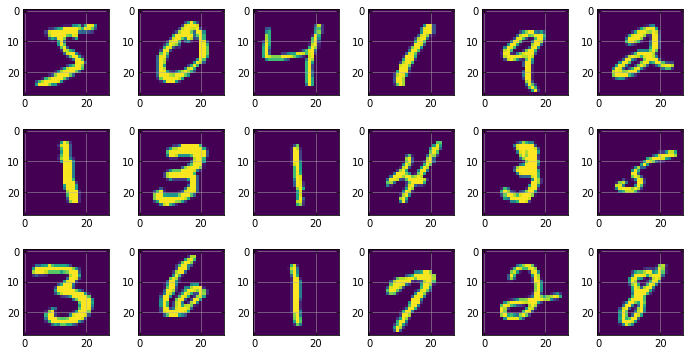

Max: 255.0
Min: 0.0
Shape: (70000, 784)
Labels and counts: Counter({'1': 7877, '7': 7293, '3': 7141, '2': 6990, '9': 6958, '0': 6903, '6': 6876, '8': 6825, '4': 6824, '5': 6313})


In [3]:
fig, axs = plt.subplots(3,6,figsize=(12,6))
axs = axs.flatten()
N_plot = len(axs)
for i in range(N_plot):
    axs[i].imshow(mnist.data.values[i].reshape((N1,N1)))
plt.show()
print('Max:', np.max(mnist.data.values))
print('Min:', np.min(mnist.data.values))
print('Shape:', np.shape(mnist.data.values))
print('Labels and counts:', Counter(mnist['target']))

The dataset consists of 70000 greyscale images. The images are encoded as 28 by 28 pixels, taking values between 0 and 255. The labels are characters representing the digits 0 to 9, and we can see that there are **roughly equal counts for each label** in the dataset - there are more 1's and fewer 5's, but the counts are all around 7000.

Let's split up the dataset for training and testing. Two sets won't suffice, however - we'll also need a set for hyperparameter tuning, which we'll call the validation set.
We'll split the dataset up into a **training set** with half the data, and a **validation set** and **test set** with a quarter of the data each.
The hyperparameters we'll tune are the features that are fed into the model.
The validation set cannot give us a true estimate of the error, since it will be biased to seem
more accurate than it actually is.
When we evaluate the score on the test set for each model, at the very end, that will give us an
**estimate of the error** of the model.

Lets print the counts for the three sets - ideally we would have a perfectly even split of labels. But, if the label distribution
in the training set is uneven, then at the very least we don't want it to be uneven in the same way that the validation and
test sets are uneven - this would increase the risk of the model overfitting to the distribution,
artificially inflating our test scores.

In [4]:
X = mnist['data'].values
y = mnist['target']
test_size = 0.5
X_train, X_nottrain, y_train, y_nottrain = train_test_split(X, y, test_size=test_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=0.5, random_state=43)
for grp in [X_train, X_valid, X_test]:
    print(np.shape(grp))
for grp in [y_train, y_valid, y_test]:
    print('Labels and counts:', Counter(grp))

(35000, 784)
(17500, 784)
(17500, 784)
Labels and counts: Counter({'1': 3950, '3': 3590, '7': 3575, '4': 3491, '8': 3481, '2': 3470, '9': 3448, '0': 3440, '6': 3386, '5': 3169})
Labels and counts: Counter({'1': 1947, '7': 1816, '9': 1801, '6': 1786, '2': 1785, '3': 1771, '0': 1732, '8': 1638, '4': 1628, '5': 1596})
Labels and counts: Counter({'1': 1980, '7': 1902, '3': 1780, '2': 1735, '0': 1731, '9': 1709, '8': 1706, '4': 1705, '6': 1704, '5': 1548})


The sets are imbalanced - we should probably fix this, but for this notebook we'll just keep an eye
on 5 in the tests below, to make sure it isn't disadvantaged too much.

Model parameters
-------

The main model we'll test is a basic MLP with **a single hidden layer** with **120 nodes**. We'll use rectified linear units (ReLU's) as activation functions. We choose our learning rate to be 1e-4.
We won't vary the network architecture in this notebook, as varying the architecture
in addition to comparing with other methods would make things a bit messy.
I chose 120 nodes after briefly testing a few possibilities on the training set, and the learning rate was chosen to be small
enough to eliminate spikes in the loss curves (caused by outlier batches fed into the stochastic weight optimizer used in the fit).

We're not going to vary too far from the defaults for the other comparison models, for the sake of keeping this notebook simple.
**Expand**

(If you want to speedily run this notebook, eg for debugging purposes, you should lower each N_samples_cut value and increase the tols in the code below.)

In [5]:
mlp_tol = 1e-4
svc_tol = 1e-3
## # It takes ages to train on the randomly permuted labels,
## # so let's make the tolerance smaller.
rand_tol = 1e-2

Nmax_to_check = [9, 10, 11, 12, 13, 14, 16, 28]#range(8,29,4)

hidden_layer_sizes = [120]
method_name, method = 'mlp', MLPClassifier
method_params = {'hidden_layer_sizes':hidden_layer_sizes, 'activation':'relu', 'random_state':16, 'tol':mlp_tol, 'learning_rate_init':1e-4, 'max_iter':4000}
rand_params  = {'hidden_layer_sizes':hidden_layer_sizes, 'activation':'relu', 'random_state':16, 'tol':rand_tol, 'learning_rate_init':1e-4, 'max_iter':4000}

#N_samples_cut = {LinearSVC.__name__:100, XGBClassifier.__name__:350, GradientBoostingClassifier.__name__:100}
N_samples_cut = {LinearSVC.__name__:10000, XGBClassifier.__name__:35000, GradientBoostingClassifier.__name__:10000}
other_methods = [XGBClassifier, LinearSVC, GradientBoostingClassifier]#, SVC]
other_params = dict()
other_params[LinearSVC.__name__] = {'max_iter':4000, 'dual':False, 'tol':svc_tol}
XGB_early_stopping_rounds = 10
other_params[XGBClassifier.__name__] = {'use_label_encoder':False, "objective":"multi:softmax","num_class":10, "eval_metric":"mlogloss"}
## # n_iter_no_change needs to be set!
other_params[GradientBoostingClassifier.__name__] = {}#{'tol':tol}

PCA with MLPClassifier
----
First, we'll use **PCA** to pick out a set of features which should hopefully capture the data well. This will help by reducing the noise, making the model more robust to overfitting.

In [6]:
pca_results = []
display_cols = ['Components','Validation score','Train score','Time taken [s]']
## # This is a bit innefficient as the PCA need only be done once,
## # and the first n_components taken at each iteration
## # (but this way lets us use the pipeline set-up more easily).
for sqrt_n_components in Nmax_to_check:
    n_components = sqrt_n_components**2
    t1 = time()
    pca = PCA(n_components=n_components, random_state=42)
    pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), (method_name, method(**method_params))])
    pca_pipe.fit(X_train, y_train)
    t2 = time()
    
    score_valid = accuracy_score(y_valid, pca_pipe.predict(X_valid))
    score_train = accuracy_score(y_train, pca_pipe.predict(X_train))
    pca_results.append([int(n_components), score_valid, score_train, t2-t1])
    print(n_components, end='\t')
    #print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
print('')
pca_results = np.array(pca_results)
pca_scores = pd.DataFrame(pca_results, columns=display_cols)

81	100	121	144	169	196	256	784	


In [64]:
pca_scores['Method'] = 'MLPClassifier'
pca_scores['Prep'] = 'PCA'
pca_scores['Samples'] = len(X_train)
pca_scores['Components'] = pca_scores['Components'].astype(np.int64)
pca_scores.style.set_caption("PCA with MPLClassifier")

,Components,Validation score,Train score,Time taken [s],Method,Prep,Samples
0,81,0.969543,0.999800,93.414233,MLPClassifier,PCA,35000
1,100,0.969600,0.999829,82.899039,MLPClassifier,PCA,35000
2,121,0.970686,0.999943,76.498930,MLPClassifier,PCA,35000
3,144,0.971886,0.999943,76.060617,MLPClassifier,PCA,35000
4,169,0.970286,0.999943,75.309293,MLPClassifier,PCA,35000
5,196,0.969829,1.000000,71.971786,MLPClassifier,PCA,35000
6,256,0.968229,1.000000,75.537513,MLPClassifier,PCA,35000
7,784,0.960857,1.000000,137.068564,MLPClassifier,PCA,35000


That's pretty good! The training score is perfect, which could be a warning sign of overfitting.
We check this by looking at the validation score, which peaks around 97.2% with 144 features.
This means that the model is correctly labelling 97.2% of the 17,500 validation samples correctly,
and so has not suffered too much from overfitting.

Let's take a look at the fraction of each class which was correctly classified.

In [41]:
con = confusion_matrix(y_valid, pca_pipe.predict(X_valid), normalize='true')
diag_acc = np.diag(con)/np.sum(con, axis=1)
ranked = sorted(zip(pca_pipe.classes_, diag_acc), key=lambda x:x[1], reverse=True)
print('Class\tScore')
for cl, sc in ranked:
    print(cl, round(sc,2), sep='\t')
#plt.imshow(con)
#plt.title('Confusion matrix')
#plt.show()
#for a in con:
#    for b in a:
#        print(round(b,3), end='\t')
#    print('')

Class	Score
1	0.98
0	0.98
6	0.97
4	0.97
7	0.96
5	0.96
9	0.95
8	0.95
3	0.95
2	0.94


The classification accuracy seems pretty even, it doesn't look like the model is concentrating too much on any particular digit.
The digit 1 may have benefitted from being the most represented in both the training and validation sets, but it doesn't look like
5 suffered too much from being the rarest in both.

Now let's take a look at the **loss curve**, to see what the training trajectory looks like. 

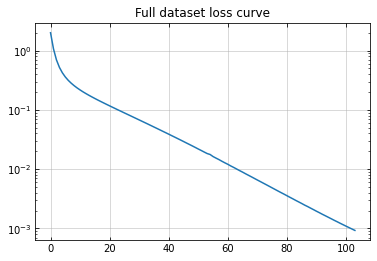

In [42]:
plt.plot(pca_pipe[method_name].loss_curve_)
plt.title('Full dataset loss curve')
plt.yscale('log')
plt.show()

The loss curve is smooth, giving us some hope that we have chosen our learning rate correctly.
It doesn't look like the loss curve has bottomed out, so we may be able to increase performance by training for longer,
but then we would run the risk of overfitting.

MLPClassifier without dimensional reduction
----
What if we train the same MLP using the **full dataset**, without applying any dimensional reduction?

In [9]:
## # Full
n_components = X_valid.shape[1]
#print(n_components)
t1 = time()
full_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
full_pipe.fit(X_train, y_train)
t2 = time()
score_valid = accuracy_score(y_valid, full_pipe.predict(X_valid))
score_train = accuracy_score(y_train, full_pipe.predict(X_train))
full_result = [int(n_components), score_valid, score_train, t2-t1]
display_cols = ['Components','Validation score','Train score','Time taken [s]']
full_score = pd.DataFrame([full_result], columns=display_cols)

In [10]:
wrong_inds = y_valid!=full_pipe.predict(X_valid)
print('Misclassifications:', len(y_valid[wrong_inds]), '\n', Counter(y_valid[wrong_inds]))

Misclassifications: 580 
 Counter({'3': 96, '8': 77, '9': 77, '2': 72, '5': 63, '4': 55, '7': 53, '6': 34, '0': 29, '1': 24})


In [66]:
full_score['Method'] = 'MLPClassifier'
full_score['Prep'] = 'None'
full_score['Samples'] = len(X_train)
full_score['Components'] = X_train.shape[1]
full_score.style.set_caption("MLPClassifier with no dimensional reduction")

,Components,Validation score,Train score,Time taken [s],Method,Prep,Samples
0,784,0.966857,1.000000,97.148667,MLPClassifier,None,35000


The first thing we notice is that training MLPClassifier with the full data, with no preprocessing,
performs quite well. It is about 0.5% lower than the best PCA result however - this is presumably because dropping
the latter PCA components reduces the noise in the training data, decreasing the variance of the resulting model.

We also notice that this model does perform better than PCA with 784 components, the number of features in
the initial training set. This is strange, as in theory the PCA reconstruction with a full complement of
features should just be a linear combination of the same information content, so we would expect the model
to converge to the same result. One possibility is slight numerical inaccuracies due to large cancellations
between the PCA components.
The PCA does reconstruct the images well, despite very large cancellations,
as we see in the test image at the end of this notebook.
However it might still be possible that these cancellations could be an issue for the neural net.

Comparison models
----
Let's compare **XGBClassifier**, **LinearSVC** and **GradientBoostingClassifier**.
The latter two are quite slow in comparison with the MLP, so **we will only train on a subset of the data**.

In [12]:
other_results = []
for mthd in other_methods:
    n_components = X_valid.shape[1]
    t1 = time()
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**other_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    print(f'Using {cut} training samples for {mthd.__name__}.', flush=True)
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        mthd_pipe.fit(X_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
    else:
        mthd_pipe.fit(X_train[:cut], y_train[:cut])
    t2 = time()
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(X_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(X_train[:cut]))
    other_results.append([mthd.__name__, cut, score_valid, score_train, t2-t1])
display_cols = ['Method','Samples','Validation score','Train score','Time taken [s]']
other_methods_scores = pd.DataFrame(other_results, columns=display_cols)

Using 35000 training samples for XGBClassifier.
Using 10000 training samples for LinearSVC.
Using 10000 training samples for GradientBoostingClassifier.


In [67]:
other_methods_scores['Prep'] = 'None'
other_methods_scores['Components'] = X_train.shape[1]
other_methods_scores.style.set_caption("Comparison models, no dimensional reduction")

,Method,Samples,Validation score,Train score,Time taken [s],Prep,Components
0,XGBClassifier,35000,0.973829,1.000000,298.208798,None,784
1,LinearSVC,10000,0.864400,0.979100,242.855655,None,784
2,GradientBoostingClassifier,10000,0.933000,0.990200,439.939308,None,784


Wow, XGBClassifier is impressive! It took about a factor of four longer than the PCA MLP took to train,
but the result is slightly better, at 97.4% vs 97.2%.

No signal, all noise
------
What if we train the same MLP using the full dataset, with the target **labels randomly permuted**?
There should be **no signal** here, the entire training set should be noise.
If our model can achieve a good training score, that would mean our model is capable of extremely overfitting the data.
By comparing with this example, we can have confidence that when using the correctly labelled data,
our model is **really learning** something.

In [69]:
## # Random (no signal, all noise)
n_components = X_valid.shape[1]
t1 = time()
rand_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**rand_params))])
permed_train = permutation(y_train)
rand_pipe.fit(X_train, permed_train)
t2 = time()
score_valid = accuracy_score(y_valid, rand_pipe.predict(X_valid))
score_train = accuracy_score(permed_train, rand_pipe.predict(X_train))
rand_result = [n_components, score_valid, score_train, t2-t1]

/home/clarkeph/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [70]:
display_cols = ['Components','Validation score','Train score','Time taken [s]']
pd.DataFrame([rand_result], columns=display_cols).style.set_caption("Randomised labels")

,Components,Validation score,Train score,Time taken [s]
0,784,0.095029,0.152029,6.494913


The training score of 22.5% is due to the ability of the model to overfit the data. As expected, the validation score is around 10%,
reflecting the even distribution of the ten classes in the training and validation sets - **the model is essentially guessing**.
It should also be kept in mind that we have set the tolerance lower here than in the other examples, to reduce computation time.
(I got similar results with lower tolerance.)

Legendre decomposition with MLPClassifier
----
Let's try using the coefficients of a **2D Legendre decomposition** as features for our model.

In [15]:
N_pixel=28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])

Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]

leg_features_sq = []
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
for to_fit in X_train_sq:
    coeffs_full = np.einsum('ia,ba->ib', Q, to_fit)
    coeffs_full = np.einsum('jb,ib->ij', Q, coeffs_full)
    leg_features_sq.append(coeffs_full)

leg_results = []
#print('Features\tValidation score\tTrain score\tTime taken [s]')
for Nmax in Nmax_to_check:
    t1 = time()
    ## # Converting pixel features to Legendre features,
    ## # reducing dimensionality and smoothing.
    ## # Training set:
    leg_features = np.array([cs[:Nmax,:Nmax].flatten() for cs in leg_features_sq])
    
    ## # Fitting the model
    leg_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
    leg_pipe.fit(leg_features, y_train)
    t2 = time()
    
    ## # Validation set:
    leg_valid = []
    for to_fit in X_valid_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_valid.append(coeffs.flatten())
    leg_valid = np.array(leg_valid)
    score_valid = accuracy_score(y_valid, leg_pipe.predict(leg_valid))
    score_train = accuracy_score(y_train, leg_pipe.predict(leg_features))
    leg_results.append([Nmax**2, score_valid, score_train, t2-t1])
    print(Nmax**2, end='\t')
print('')
display_cols = ['Components','Validation score','Train score','Time taken [s]']
leg_scores = pd.DataFrame(leg_results, columns=display_cols)

81	100	121	144	169	196	256	784	


In [71]:
leg_scores['Method'] = 'MLPClassifier'
leg_scores['Prep'] = 'Legendre decomp'
leg_scores['Samples'] = len(X_train)
leg_scores.style.set_caption("Legendre decomp with MPLClassifier")

,Components,Validation score,Train score,Time taken [s],Method,Prep,Samples
0,81,0.969886,0.996914,158.517576,MLPClassifier,Legendre decomp,35000
1,100,0.972171,0.998257,142.743756,MLPClassifier,Legendre decomp,35000
2,121,0.973771,0.999629,121.239509,MLPClassifier,Legendre decomp,35000
3,144,0.974857,0.999771,102.824961,MLPClassifier,Legendre decomp,35000
4,169,0.976571,0.999829,87.467926,MLPClassifier,Legendre decomp,35000
5,196,0.976857,0.999943,85.905572,MLPClassifier,Legendre decomp,35000
6,256,0.972457,1.000000,76.296694,MLPClassifier,Legendre decomp,35000
7,784,0.960057,1.000000,74.678507,MLPClassifier,Legendre decomp,35000


By eye, the scores and times for Legendre preprocessing seem similar to the PCA case.

PCA vs Legendre
----
Let's compare them properly, by plotting the scores and times as we increase the numbers of features.
We'll also plot the loss curves for PCA and Legendre preprocessing with 784 features.

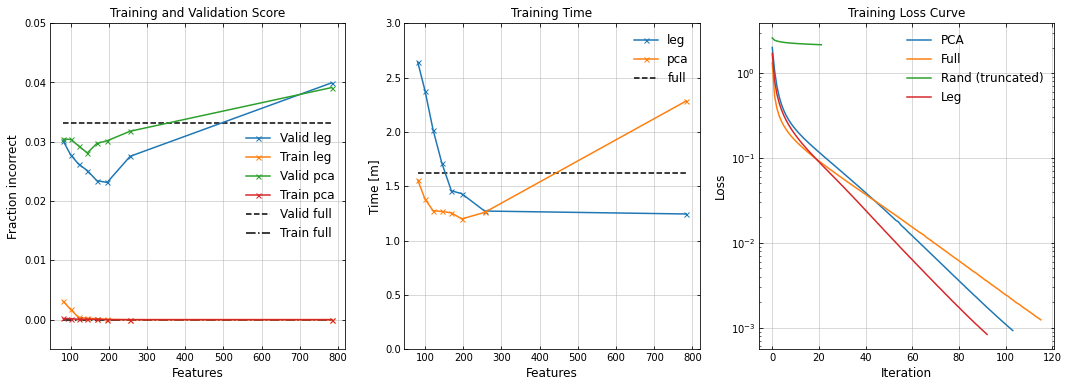

Final value of rand loss: 22 iterations gives loss=2.16.


In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot([r[0] for r in leg_results], [1-r[1] for r in leg_results], '-x', label='Valid leg')
axs[0].plot([r[0] for r in leg_results], [1-r[2] for r in leg_results], '-x', label='Train leg')
axs[1].plot([r[0] for r in leg_results], [r[3]/60 for r in leg_results], '-x', label='leg')
axs[0].plot([r[0] for r in pca_results], [1-r[1] for r in pca_results], '-x', label='Valid pca')
axs[0].plot([r[0] for r in pca_results], [1-r[2] for r in pca_results], '-x', label='Train pca')
axs[1].plot([r[0] for r in pca_results], [r[3]/60 for r in pca_results], '-x', label='pca')
xmin, xmax = min(pca_results[:,0]), max(pca_results[:,0])
axs[0].hlines(1-full_result[1], xmin, xmax, linestyles='--', label='Valid full')
axs[0].hlines(1-full_result[2], xmin, xmax, linestyles='-.', label='Train full')
axs[1].hlines(full_result[3]/60, xmin, xmax, linestyles='--', label='full')
axs[2].plot(pca_pipe[method_name].loss_curve_, '-', label='PCA')
axs[2].plot(full_pipe[method_name].loss_curve_, '-', label='Full')
axs[2].plot(rand_pipe[method_name].loss_curve_[:len(leg_pipe[method_name].loss_curve_)], '-', label='Rand (truncated)')
axs[2].plot(leg_pipe[method_name].loss_curve_, '-', label='Leg')
axs[2].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Training and Validation Score')
axs[1].set_title('Training Time')
axs[2].set_title('Training Loss Curve')
axs[0].set_xlabel('Features')
axs[0].set_ylabel('Fraction incorrect')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Time [m]')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Iteration')
axs[0].set_ylim(-0.005, 0.05)
axs[1].set_ylim(0, 3.)
plt.show()
print(f"Final value of rand loss: {len(rand_pipe[method_name].loss_curve_)} iterations gives loss={round(rand_pipe[method_name].loss_curve_[-1],2)}.")

The validation score curves show us that the Legendre features are more **robust against overfitting**,
as it stays good with a larger number of features **QUANTIFY**.
**Spikes in the loss curves** are due to having a learning rate that is too large.
We have reduced our learning rate here to **1e-4** to remove these spikes, which are due to an **outlier minibatch**.
The plots show there is **no significant difference in time taken to train**,
though this isn't a totally fair comparison - the PCA is being performed for every iteration of the loop, when in reality it
only needs to be performed once, and the first n components taken.

Using all the features leads to overfitting. PCA helps, but since the features are picked based on variance they might not actually hold the cluster information. Legendre coefficients as features cut out noise, but can also make use of more features before giving in to overfitting, hence achieve a better validation score (though the difference is only marginal, 97.7% compared to 97.2%).

Comparison models, with Legendre decomposition
----
What about training our comparison models (XGBClassifier, LinearSVC, GradientBoostingClassifier) on the Legendre features,
choosing the number of Legendre features that gave us the best result with MLPClassifier?

In [18]:
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
Nmax_sq = leg_scores['Components'][leg_scores['Validation score']==leg_scores['Validation score'].max()].values[0]
Nmax = int(np.sqrt(Nmax_sq))
print(f'Maximum at Nmax={Nmax}, so {Nmax_sq} components.')
## # Converting pixel features to Legendre features,
## # reducing dimensionality and smoothing.
## # Training set:
leg_train = []
for to_fit in X_train_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_train.append(coeffs.flatten())
leg_train = np.array(leg_train)

## # Validation set:
leg_valid = []
for to_fit in X_valid_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_valid.append(coeffs.flatten())
leg_valid = np.array(leg_valid)
    
#######

leg_other_results = []
for mthd in other_methods:
    n_components = leg_valid.shape[1]
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**other_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    print(f'Using {cut} training samples for {mthd.__name__}.', flush=True)
    t1 = time()
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        mthd_pipe.fit(leg_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
    else:
        mthd_pipe.fit(leg_train[:cut], y_train[:cut])
    t2 = time()
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(leg_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(leg_train[:cut]))
    leg_other_results.append([mthd.__name__, cut, score_valid, score_train, t2-t1])
display_cols = ['Method', 'Samples', 'Validation score', 'Train score', 'Time taken [s]']
other_methods_scores_leg = pd.DataFrame(leg_other_results, columns=display_cols)

Maximum at Nmax=14, so 196 components.
Using 35000 training samples for XGBClassifier.
Using 10000 training samples for LinearSVC.
Using 10000 training samples for GradientBoostingClassifier.


In [72]:
other_methods_scores_leg['Prep'] = 'Legendre decomp'
other_methods_scores_leg['Components'] = leg_train.shape[1]
other_methods_scores_leg.style.set_caption("Legendre decomp with comparison models")

,Method,Samples,Validation score,Train score,Time taken [s],Prep,Components
0,XGBClassifier,35000,0.972000,1.000000,359.778121,Legendre decomp,196
1,LinearSVC,10000,0.908800,0.928600,6.490337,Legendre decomp,196
2,GradientBoostingClassifier,10000,0.936300,0.996500,600.565901,Legendre decomp,196


Some interesting results here!

**XGBClassifier** took a little longer, and got an accuracy score 0.2% lower,
which we can assume is due to dropping from 784 components to 196.
**LinearSVC** has vastly improved, however - around thirty times faster, and an accuracy score increase
of around 5%! An accuracy of 0.91 is still quite low compared to the other methods, but given the vast increase
in training speed we now could try increasing the number of training samples from 10000 to the full training set.
**GradientBoostingClassifier** has performed about the same as it did with all the features, taking slightly longer
here but achieving a slightly better accuracy.

Ranking the methods
----
Let's rank all the methods we've tried so far! We'll only include the best PCA example and the best Legendre example in
the following table, which we will order by validation score.

In [73]:
## # Change this to a plot?
col1 = 'Method'
col2 = 'Prep'
pca_inds = pca_scores['Validation score']==pca_scores['Validation score'].max()
leg_inds = leg_scores['Validation score']==leg_scores['Validation score'].max()
dfs = [other_methods_scores, other_methods_scores_leg, pca_scores[pca_inds], leg_scores[leg_inds], full_score]
temp = pd.concat(dfs)#, keys=keys, names=[col2])
temp['Components'] = temp['Components'].astype(np.int64)
temp['Time taken [s]'] = np.round(temp['Time taken [s]'])
temp = temp.set_index([col1, col2], drop=True).sort_values('Validation score', ascending=False)
temp.style.set_caption("All models, ranked")

**Add note about tol being different!!**
**Compare loss curves?**

The results are clear - the two models that were computationally efficient enough to take advantage of the full
training set, **MLPClassifier and XGBClassifier**, perform a few percent better than GradientBoostingClassifier and LinearSVC.
All of the models performed better with **dimensional reduction**, except XGBClassifier which managed to extract the signal itself
from the raw (standardised) data. For the MLPClassifier, the Legendre coefficients performed better as features than the PCA
components did, however only by 0.5% (and of course, PCA has the advantage of being very widely studied and easily
accessible in the standard libraries).

Based on these results, we will choose two models; **MLPClassifier with the Legendre dimensional reduction** (14X14 components)
and **XGBClassifier, with no preprocessing** (beyond standard scaling, of course).

And now for the grand finale - testing our chosen models on our test set, to estimate their true error rate.

Grand finale
-----
To state something incredibly obvious, the accuracy score on the training set is not going to be a good estimate for the model's accuracy on unseen data, as this is the data the model was, well, trained on.
Similarly, the accuracy score on the validation set won't be a good estimate of the error on unseen data either - this is the set
we used to choose our hyperparameters, so the error will be **biased** to be smaller than the true error.
This is why **we have kept a quarter of our data locked away** up until now. Now that all our tuning is done
we can finally apply our model to that data and estimate the **true error rate** of the model.
Once we've seen this, we can't tune our model any further and still have an honest estimate of our error rate, so we better be sure we're ready!

First, XGBClassifier with no dimensional reduction:

In [21]:
## # XGBoost, None, on test

XGB_test_result = []

XGB_pipe = Pipeline([('scaler', StandardScaler()), (XGBClassifier.__name__, XGBClassifier(**other_params[XGBClassifier.__name__]))])
cut = N_samples_cut[XGBClassifier.__name__]
print(f'Using {cut} training samples for {XGBClassifier.__name__}.', flush=True)
t1 = time()
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
XGB_pipe.fit(X_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
t2 = time()
score_test, score_train = 0., 0.
score_test = accuracy_score(label_encoder.transform(y_test[:cut]), XGB_pipe.predict(X_test[:cut]))
score_train = accuracy_score(label_encoder.transform(y_train[:cut]), XGB_pipe.predict(X_train[:cut]))
XGB_test_result.append([XGBClassifier.__name__, cut, score_test, score_train, t2-t1, 'None', X_train.shape[1]])

In [43]:
y_test_encoded = np.array(label_encoder.transform(y_test[:cut].astype("category")))
#print(np.shape(y_test_encoded))
#print(np.shape(XGB_pipe.predict(X_test)))
print('Misclassifications\n',Counter(y_test[y_test_encoded!=XGB_pipe.predict(X_test)]))
display_cols = ['Method', 'Samples', 'Test score', 'Train score', 'Time taken [s]', 'Prep', 'Components']
XGB_test_result_scores = pd.DataFrame(XGB_test_result, columns=display_cols)

Misclassifications
 Counter({'3': 70, '8': 68, '9': 65, '7': 55, '5': 53, '2': 51, '4': 49, '1': 34, '0': 32, '6': 23})


And second, MLPClassifier using Legendre decomposition:

In [45]:
## # MLP, Legendre, on test
N_opt = int(np.sqrt(leg_scores['Components'][leg_inds]))
print(f'Using Nmax={N_opt}')

X_train_sq = X_train.reshape((-1,28,28))
X_test_sq = X_test.reshape((-1,28,28))
leg_train = []
for to_fit in X_train_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:N_opt], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:N_opt], coeffs)
    leg_train.append(coeffs.flatten())
leg_train = np.array(leg_train)

## # Test set:
leg_test = []
for to_fit in X_test_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:N_opt], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:N_opt], coeffs)
    leg_test.append(coeffs.flatten())
leg_test = np.array(leg_test)
    
#######

MLP_test_result = []

n_components = leg_test.shape[1]
MLP_pipe = Pipeline([('scaler', StandardScaler()), (MLPClassifier.__name__, MLPClassifier(**method_params))])
t1 = time()
MLP_pipe.fit(leg_train, y_train)
t2 = time()
score_test, score_train = 0., 0.
score_test = accuracy_score(y_test, MLP_pipe.predict(leg_test))
score_train = accuracy_score(y_train, MLP_pipe.predict(leg_train))
MLP_test_result.append([MLPClassifier.__name__, X_train.shape[0], score_test, score_train, t2-t1, 'Legendre decomp', X_train.shape[1]])

display_cols = ['Method', 'Samples', 'Test score', 'Train score', 'Time taken [s]', 'Prep', 'Components']
MLP_test_result_score = pd.DataFrame(MLP_test_result, columns=display_cols)

Using Nmax=14


In [44]:
print('Misclassifications\n',Counter(y_test[y_test!=MLP_pipe.predict(leg_test)]))

Misclassifications
 Counter({'8': 76, '3': 65, '4': 48, '9': 47, '2': 45, '5': 40, '0': 32, '7': 32, '1': 26, '6': 25})


In [74]:
pd.concat([XGB_test_result_scores, MLP_test_result_score]).style.set_caption("Results on test set")

,Method,Samples,Test score,Train score,Time taken [s],Prep,Components
0,XGBClassifier,35000,0.971429,1.000000,283.380063,None,784
0,MLPClassifier,35000,0.975086,0.999943,87.049292,Legendre decomp,784


So that's our final result - the estimated accuracy of our XGBClassifier model is 97.1%, and 97.5% for our
MLPClassifier (dimensionally reduced using Legendre decomposition).

Conclusions
-----
Our neural net performed pretty well! Using only the most basic architecture it managed to (slightly) outperform
our XGBoost model in accuracy, and far outperform it in speed of training. The neural net didn't achieve this on
its own, however - by taking a Legendre decomposition of the original image and providing those coefficients as
features for the model, it was able to ignore the noise and focus on fitting the real signal.

I'm sure there are many ways we could improve all of these implementations - systemised experimentation using
hyperparameter grid searches, and using cross-validation instead of hold-out being two examples.
However, my motivations in writing this notebook were simply to convince myself that neural networks are impressive,
and to compare PCA and Legendre decomposition as methods of dimensional reduction, and the results we have obtained
achieve those goals.

Thank you for reading this far! See below for some visualisations of PCA vs Legendre decompositions.

Bonus - visualising the processed features
---

How well do the Legendre/PCA decompositions capture the image?
Recall that the processed features do not actually have to be able to reconstruct the image perfectly,
as they only need sufficient infomation to distinguish between the digits. In fact, it is
preferable if they can't reconstruct the noise!
Still, let's take a look at what the features actually look like.

In the following images the **colour scheme is not standardised!**
To add a metric for the amplitude what's being plotted, I've added the variance of the pixels in the title of
each image and scaled the target image to have unit variance.

2	4	6	8	10	12	14	16	18	20	22	24	26	28	

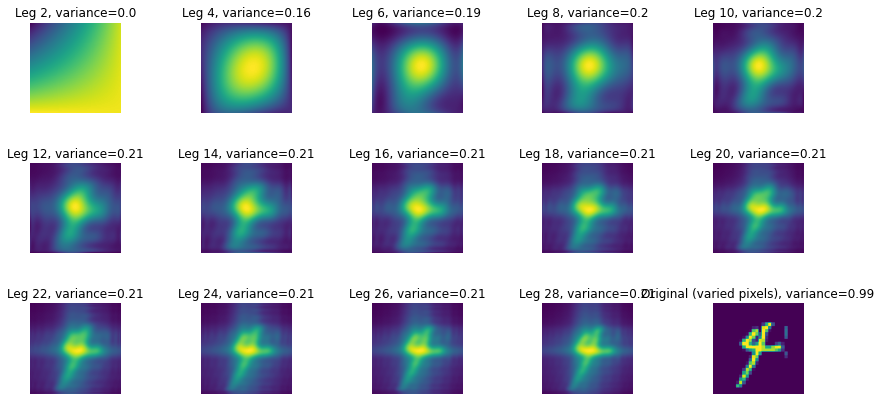

In [81]:
## # 2d
N_pixel = 28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])
mnist_ind = 53
## # Careful to copy, not view!
to_fit_example = np.copy(mnist['data'].values[mnist_ind].reshape((28,28)))
to_fit_example -= to_fit_example.mean()
to_fit_example = to_fit_example/to_fit_example.std()
def func(x, y):
    x = np.clip(np.ceil((1+x)*N_pixel/2), 0, 27)
    y = np.clip(np.ceil((1+y)*N_pixel/2), 0, 27)
    temp = to_fit_example[y.astype(np.int64), x.astype(np.int64)]
    return temp

N_plot = 150
xs = np.linspace(-1, 1, N_plot, endpoint=True)
ys = np.linspace(-1, 1, N_plot, endpoint=True)
f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
fns = func(f_xs, f_ys)

## # We should already have this from above?
#Q = np.zeros((N_pixel, N_pixel))
#for n in range(N_pixel):
#    for i in range(N_pixel):
#        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]
fig, axs = plt.subplots(3, 5, figsize=(12,6))
axs = axs.flatten()
recon_res = []
for ind, Nmax in enumerate(range(2, 29, 2)):#range(1,32,10):
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit_example)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    recomp = np.dot(coeffs, [eval_legendre(n, xs) for n in range(Nmax)])
    recomp = np.dot(recomp.T, [eval_legendre(n, xs) for n in range(Nmax)]).flatten()
    recon_res.append([Nmax, np.sum((recomp-fns)**2)/np.sum(fns**2)])
    scale = (28./N_plot)**2 # Relative number of pixels
    axs[ind].set_title(f'Leg {Nmax}, variance={round(np.var(recomp),2)}')
    #axs[ind].set_title(f'Leg {Nmax}, log_sq_sum={round(np.log10(scale*np.sum(recomp**2)),2)}')
    axs[ind].imshow(recomp.reshape((N_plot,N_plot)), label='recomp', extent=[-1, 1, -1, 1])
    print(Nmax, end='\t', flush=True)
    axs[ind].axis('off')
recon_res = np.array(recon_res)
axs[-1].set_title(f'Original (varied pixels), variance={round(np.var(fns),2)}')
axs[-1].axis('off')
axs[-1].imshow(fns.reshape((N_plot,N_plot)), extent=[-1, 1, -1, 1])
plt.tight_layout()
plt.show()

#fig, ax = plt.subplots(1,1,figsize=(6,3))
#ax.set_title('Legendre reconstruction error')
#ax.plot(recon_res[:,0]**2, recon_res[:,1], '-x')
#ax.set_ylabel('Error')
#ax.set_xlabel('Components')
#plt.show()

The Legendre reconstruction only manages to achieve a reconstruction score of around 0.65, but this is to be expected,
as they could never reconstruct the sharp edges of the pixels. Despite this, we can see from the images that
they do provide a good representation of the written digit.

Now let's see what the same reconstruction looks like for PCA.

In [75]:
## # Plot the coefficients of a particular image.
#fig, axs = plt.subplots(1, 3, figsize=(18,6))
#axs[0].set_title('Original')
#axs[1].set_title(f'Nmax={Nmax}')
#axs[2].set_title('Coefficients')
#axs[0].imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
#axs[1].imshow(recomp.reshape((N_plot, N_plot)), label='recomp', extent=[-1, 1, -1, 1])
#axs[2].imshow(coeffs[::-1,:], extent=[0, Nmax, 0, Nmax])
#plt.show()
########################

2	4	6	8	10	12	14	16	18	20	22	24	26	28	


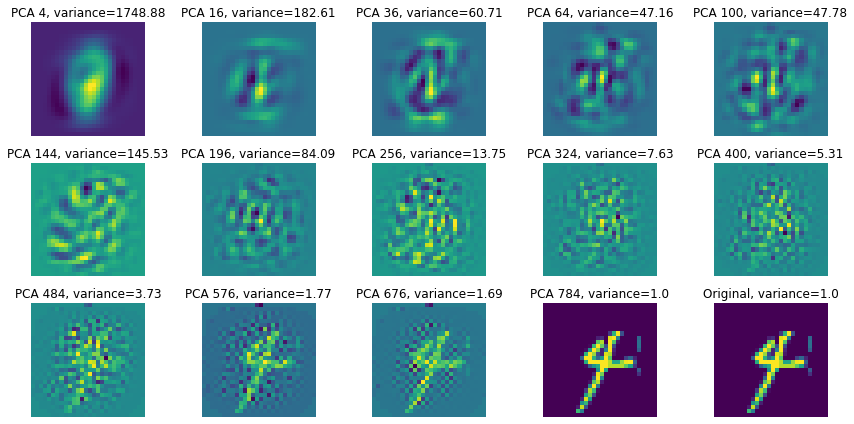

In [56]:
fig, axs = plt.subplots(3, 5, figsize=(12,6))
axs = axs.flatten()
pca_recon = []
for ind, sqrt_n_components in enumerate(range(2, 29, 2)):
    ## # Should rewrite to do full once, then just use the first n.
    pca = PCA(n_components=sqrt_n_components**2, random_state=42)
    pca_only_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    pca_only_pipe.fit(X_train)
    pca_fit = pca_only_pipe.transform(to_fit_example.reshape((1,-1)))
    pca_inv_fit = pca_only_pipe.inverse_transform(pca_fit).reshape((28,28))
    axs[ind].set_title(f'PCA {sqrt_n_components**2}, variance={round(np.var(pca_inv_fit),2)}')
    #axs[ind].set_title(f'PCA {sqrt_n_components**2}, log_sq_sum={round(np.log10(np.sum(pca_inv_fit**2)),2)}')
    axs[ind].imshow(pca_inv_fit, label='recomp', extent=[-1, 1, -1, 1])
    print(sqrt_n_components, end='\t', flush=True)
    axs[ind].axis('off')
    pca_recon.append([sqrt_n_components**2, np.sum((pca_inv_fit-to_fit_example)**2)/np.sum(to_fit_example**2)])
pca_recon = np.array(pca_recon)
print('')
axs[-1].set_title(f'Original, variance={round(np.var(to_fit_example),2)}')
axs[-1].axis('off')
axs[-1].imshow(to_fit_example, label='recomp', extent=[-1, 1, -1, 1])
plt.tight_layout()
plt.show()

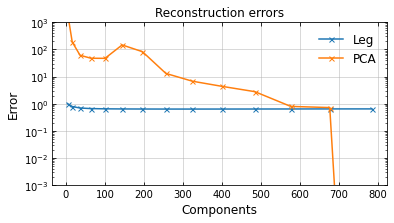

Final Leg residual: 0.65
Final PCA residual: 1.5486309709670493e-26


In [80]:
#print(pca_recon[-2,0], round(pca_recon[-2,1],2), sep=': ')
#print(pca_recon[-1,0], round(pca_recon[-1,1],2), sep=': ')
fig, ax = plt.subplots(1,1,figsize=(6,3))
ax.set_title('Reconstruction errors')
ax.plot(recon_res[:,0]**2, recon_res[:,1], '-x', label='Leg')
ax.plot(pca_recon[:,0], pca_recon[:,1], '-x', label='PCA')
ax.set_ylabel('Error')
ax.set_xlabel('Components')
plt.yscale('log')
plt.ylim(1e-3, 1e3)
plt.legend()
plt.show()
print(f'Final Leg residual: {round(recon_res[-1,1],2)}')
print(f'Final PCA residual: {pca_recon[-1,1]}')

Wow, there is a big difference in how PCA and Legendre polynomials reconstruct the image! The Legendre polynomials always have a reasonable, human-readable, approximation to the final result. Even if they could never efficiently capture the sharp edges of the pixels,
the magnitude of the the residuals is never much larger than the pixel values themselves.
The PCA features, on the other hand, have gigantic residuals! The convergence is far less smooth than in the Legendre case,
and only when the number of components nears the full 784 does the reconstruction error beat the Legendre case,
becoming effectively perfect.

Visualising the Legendre basis
----
What do the two-dimensional Legendre basis functions look like?

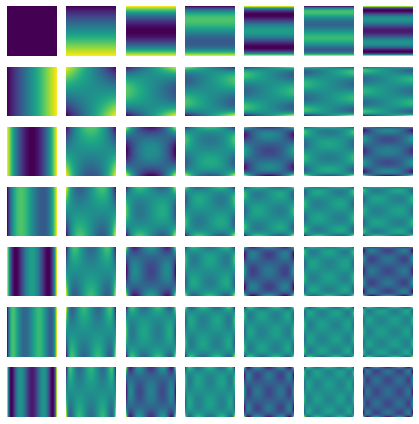

In [58]:
#print(coeffs[:3,:3])
#print(coeffs[-3:,-3:])
N_plot = 101
ps = np.linspace(-1, 1, N_plot, endpoint=True)
xs, ys = np.meshgrid(ps, ps)[0].flatten(), np.meshgrid(ps, ps)[1].flatten()
Nmax_plot = 7
fig, axs = plt.subplots(Nmax_plot, Nmax_plot, figsize=(6,6))
for n1 in range(Nmax_plot):
    temp = eval_legendre(n1, xs)*np.sqrt(n1+0.5)
    for n2 in range(Nmax_plot):
        temp2 = temp*eval_legendre(n2, ys)*np.sqrt(n2+0.5)
        #axs[n1][n2].set_title(f'{n1}, {n2}')
        axs[n1][n2].imshow(temp2.reshape((N_plot,N_plot)))
        axs[n1][n2].axis('off')
plt.tight_layout()
plt.show()